## Order of Notebook 

1. Importing Packages
2. Functions and constants
3. Reading Data
4. Analysis
5. Plots

## Importing Packages for Python 

In [2]:
import numpy as np 
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
from osgeo import gdal
import xarray as xr # imports net cdf data 
from scipy.io import loadmat
from matplotlib import colormaps
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import cftime
import scipy.stats
from scipy.stats import ttest_rel
from matplotlib import axes
import math

viridis = mpl.colormaps['viridis'].resampled(8)
plt.rcParams['font.sans-serif'] = 'Arial' 
plt.rcParams['font.size'] = 7 
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams['mathtext.it'] = 'Arial'
plt.rcParams['figure.facecolor'] = 'white' 
plt.rcParams['figure.dpi'] = 100

## Loading Dataset from net CDF files 

In [42]:
# Loading Monthly mean sst data (1979 - 2024) 
data_netcdf = xr.open_dataset('sst.mnmean.nc') # importing net cdf file sst.mnmean.nc 
lon = data_netcdf.lon # defining longitude
lat = data_netcdf.lat # defining latitude 
time = data_netcdf.time # defining time 
sst = data_netcdf.sst # defining SST 
sst_1979 = data_netcdf.sst.sel(time=slice("1979-01-01", "2023-12-01")) # reducing time data to be within 1979-2024 

# Loading Long term mean data (lat x lon x time = 89 x 180 x 12) 
data_netcdf_ltm = xr.open_dataset("sst.mon.ltm.1981-2010.nc", decode_times=False) # opening ltm sst data, ignoring time 

# LTM for date range 1979 - 2024 
start_date = 1979 # create new start time for dataset 
ltm_time = pd.date_range(start=start_date, periods=12, freq="MS")
data_netcdf_ltm = data_netcdf_ltm.assign_coords(time=("time", ltm_time)) # add time varale back into data array with new time def 
years = np.arange(1979, 2024)  # 47 years not incl 2025 
ltm_repeated = xr.concat([data_netcdf_ltm.sst] * len(years), dim="time")
full_time = pd.date_range(start="1979-01-01", periods=len(years) * 12, freq="MS") # Assign correct time axis (matching SST dataset)
ltm_1979 = ltm_repeated.assign_coords(time=("time", full_time))
anom_1979 = sst_1979 - ltm_1979 # creating sst anomaly from 1979 - 2024
# Defining Nino 34 region
nino34 = anom_1979.sel(lat=slice(5,-5),lon=slice(190,240)).mean(dim=('lat', 'lon')).squeeze()


# LTM for date range 1900 - 2024 
sst_1900 = data_netcdf.sst.sel(time=slice("1900-01-01", "2023-12-01")) # reducing time data to be within 1900-2024 

start_date_2 = 1900 # create new start time for dataset 
ltm_time_2 = pd.date_range(start=start_date, periods=12, freq="MS")
data_netcdf_ltm_2 = data_netcdf_ltm.assign_coords(time=("time", ltm_time_2)) # add time varale back into data array with new time def 
years_2 = np.arange(1900, 2024) 
data_netcdf_ltm_2 = data_netcdf_ltm.assign_coords(time=("time", ltm_time_2))  
ltm_repeated_2 = xr.concat([data_netcdf_ltm_2.sst] * len(years_2), dim="time")
full_time_2 = pd.date_range(start="1900-01-01", periods=len(years_2) * 12, freq="MS") # Assign correct time axis (matching SST dataset)
ltm_1900 = ltm_repeated_2.assign_coords(time=("time", full_time_2))
anom_1900 = sst_1900 - ltm_1900 # creating sst anomaly from 1900 - 2024
# Defining N34 Region 
nino34_1900 = anom_1900.sel(lat=slice(5,-5),lon=slice(190,240)).mean(dim=('lat', 'lon')).squeeze()

# Using Long Term Mean and Monthly Mean Values to create an Anomaly from 1979 - 2024
# loading in matlab data for coastlines 
data_mat = loadmat('coast.mat') 
coastlon = data_mat['long'].flatten() 
coastlat = data_mat['lat'].flatten()
coastlon[coastlon<0] = coastlon[coastlon<0]+360 
ns_to_decade = 1e+9*60*60*24*365.25*10 # converting nanoseconds to decade to be used later 

# Load in Eastern Australia Dataset 
# SEPTEMBER 
sep_EA = pd.read_csv('september_EA_excel.csv') # importing september rainfall anomaly csv 
rainfall_sep   = sep_EA['Rainfall Anomaly'] # defining y variable 
yrs_sep = pd.to_datetime(sep_EA['Year'].astype(str), format='%Y%m') # defining years in dataset, and converting to date-time format 

# OCTOBER
oct_EA = pd.read_csv('october_EA_excel.csv') # importing october rainfall anomaly csv
rainfall_oct   = oct_EA['Rainfall Anomaly'] # defining y variable 
yrs_oct = pd.to_datetime(oct_EA['Year'].astype(str), format='%Y%m') # defining years in dataset, and converting to date-time format 

# NOVEMBER 
nov_EA = pd.read_csv('november_EA_excel.csv') # importing nov rainfall anomaly csv
yr_nov   = nov_EA['Year'] # defining x varaible 
rainfall_nov   = nov_EA['Rainfall Anomaly'] # defining y variable 
yrs_nov = pd.to_datetime(nov_EA['Year'].astype(str), format='%Y%m') # defining years in dataset, and converting to date-time format 

years = list(range(1900, 2024)) # creating own y variable [years] that is formatted correctly 

# extracting the SSTA for each Sept, Oct, Nov in the Nino 3.4 region 
nino34_sep = nino34_1900.sel(time=yrs_sep.to_numpy(), method="nearest")
nino34_oct = nino34_1900.sel(time=yrs_oct.to_numpy(), method="nearest")
nino34_nov = nino34_1900.sel(time=yrs_nov.to_numpy(), method="nearest")

# Concatenating the Sept/Oct/Nov into one Spring dataset 
SON_N34 = np.concatenate((nino34_sep, nino34_oct, nino34_nov))
rainfall_SON = np.concatenate((rainfall_sep, rainfall_oct, rainfall_nov))
yr_SON = np.concatenate((yrs_sep, yrs_oct, yrs_nov))

In [43]:
# ENSO Indices 

#La Nina
la_nina_indices = SON_N34 < -0.5  #any SSTA values less than 0.05 
la_nina_N34 = SON_N34[la_nina_indices] # defines SON values within La Nina indices
la_nina_precipitation = rainfall_SON[la_nina_indices] # defines where precipitation is within La Nina indices 

#El Nino (same analysis as La Nina) 
el_nino_indicies = SON_N34 > 0.5 
el_nino_N34 = SON_N34[el_nino_indicies]
el_nino_precipitation = rainfall_SON[el_nino_indicies]

## Analysis (Linear Regression + Statistical Significance Tests)

In [46]:
# xarray linear regress function 
regression = anom_1979.polyfit(dim='time', deg=1) # linear regression across time and sst in 1st degree polynomial 
# performing a t-test to asses significant regions of SST warming 
t_stat, p_value = scipy.stats.ttest_rel(sst_1979, ltm_1979) 
p_value = np.array(p_value) # convert into np.array

# Creating regression for N34 index and EA rainfall 
reg_N34_rainfall = np.polyfit(SON_N34, rainfall_SON, deg=1, rcond=None, full=False, w=None, cov=False)

# linear regression of precipitation values and N34 index values
la_nina_reg = np.polyfit(la_nina_N34, la_nina_precipitation, deg=1, rcond=None, full=False, w=None, cov=False)
el_nino_reg = np.polyfit(el_nino_N34, el_nino_precipitation, deg=1, rcond=None, full=False, w=None, cov=False)

C:\Users\keila\miniconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:430: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return hypotest_fun_in(*args, **kwds)


## Plots 

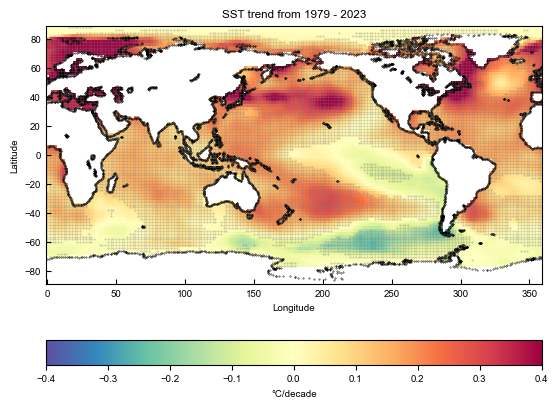

In [47]:
SSTA_regression = (regression.polyfit_coefficients.sel(degree=1)*ns_to_decade).plot(add_colorbar=False, vmin= -0.4, vmax= 0.4,cmap='Spectral_r') # Plotting the linear regression coefficient, across all lat x lon values

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('SST trend from 1979 - 2023')
plt.tick_params(axis="both",direction="in", left="off", labelleft="on")
cbar = plt.colorbar(SSTA_regression, label='°C/decade', location='bottom')

# Plot coastline data 
plt.scatter(coastlon, coastlat, color='black', s=0.1)

lon, lat = np.meshgrid(regression.lon, regression.lat)  
p_value_mask = p_value < 0.05 # identify where p > 0.05
stipple_lon = lon[p_value_mask] 
stipple_lat = lat[p_value_mask] 
plt.scatter(stipple_lon, stipple_lat, color='grey', s=0.7, alpha=0.5, marker ='.') # maps the overlay stipple of p values
plt.savefig('sst.png',dpi=300, bbox_inches = 'tight')

## Creating Plot for Eastern Australia Rainfall (1900 - 2024)

<function matplotlib.pyplot.show(close=None, block=None)>

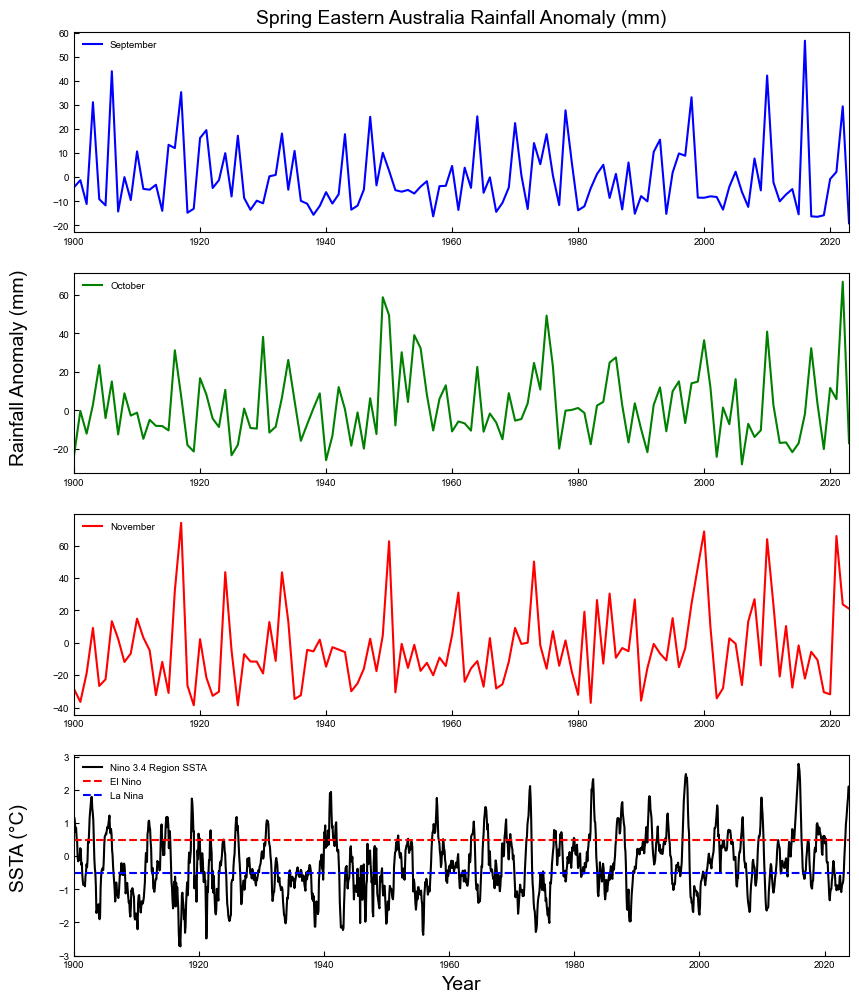

In [49]:
fig, axes = plt.subplots(4, 1, figsize=(10, 12))  # Creates 4 rows, 1 column

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.2)  # Increase vertical spacing

# September plot
axes[0].plot(years, rainfall_sep, label='September', color='b')
axes[0].legend(loc='upper left', frameon=False)
axes[0].set_title('Spring Eastern Australia Rainfall Anomaly (mm)', fontsize = '14')
axes[0].tick_params(axis="both",direction="in", left="off", labelleft="on")
axes[0].set_xlim (left = 1900, right= 2023)

# October plot
axes[1].plot(years, rainfall_oct, label='October', color='g')
axes[1].legend(loc='best', frameon=False)
axes[1].tick_params(axis="both",direction="in", left="off", labelleft="on")
axes[1].set_xlim (left = 1900, right= 2023)

# November plot
axes[2].plot(years, rainfall_nov, label='November', color='r')
#axes[2].set_xlabel('Year')
axes[2].legend(loc='upper left', frameon=False)
axes[2].tick_params(axis="both",direction="in", left="off", labelleft="on")
axes[2].set_xlim (left = 1900, right= 2023)

# Nino 3.4 plot
axes[3].plot(full_time_2, nino34_1900, label='Nino 3.4 Region SSTA', color='black')
axes[3].axhline(y=0.5, color='r', linestyle='--', label='El Nino')
axes[3].axhline(y=-0.5, color='b', linestyle='--', label='La Nina')
axes[3].legend(loc='upper left', frameon=False)
axes[3].set_xlabel('Year', fontsize = '14')
axes[3].tick_params(axis="both",direction="in", left="off", labelleft="on")
axes[3].set_xlim (pd.to_datetime('1900-01-01'), right= pd.to_datetime('2023-12-01'))


fig.text(0.07, 0.6, 'Rainfall Anomaly (mm)', va='center', ha='center', rotation='vertical', fontsize = '14')
fig.text(0.07, 0.2, 'SSTA (°C)', va='center', ha='center', rotation='vertical', fontsize = '14')


# Save the figure
plt.savefig('EArainfall.png', dpi=300, bbox_inches='tight')
plt.show

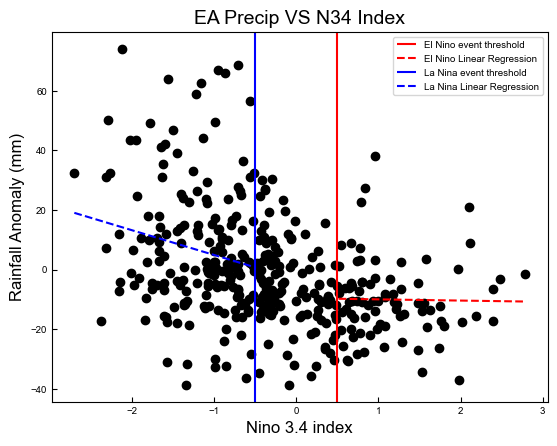

In [50]:

fig = plt.scatter(SON_N34,rainfall_SON, color = 'black')
la_nina = np.linspace(np.min(la_nina_N34), np.max(la_nina_N34))
el_nino = np.linspace(np.min(el_nino_N34), np.max(el_nino_N34))
ymin, ymax = plt.ylim()
plt.ylim(ymin, ymax)
plt.title('EA Precip VS N34 Index', fontsize = '14')
plt.tick_params(axis="both",direction="in", left="off", labelleft="on")
plt.vlines(x=0.5, ymin = ymin, ymax = ymax, color = 'r', linestyles= 'solid', label = 'El Nino event threshold')
plt.plot(el_nino,np.polyval(el_nino_reg,el_nino),color = 'r',linestyle= 'dashed', label = 'El Nino Linear Regression')
plt.vlines(x=-0.5, ymin = ymin, ymax = ymax, color = 'b', linestyles= 'solid', label = 'La Nina event threshold')
plt.plot(la_nina,np.polyval(la_nina_reg,la_nina),color = 'b',linestyle= 'dashed', label = 'La Nina Linear Regression')
plt.xlabel('Nino 3.4 index', fontsize = '12')
plt.ylabel('Rainfall Anomaly (mm)',fontsize = '12')
plt.legend()

plt.savefig('N34_EA_precip.png',dpi=300, bbox_inches = 'tight')
plt.show